# DA3 Assignment 2
---
## AirBnB Price Prediction - Buenos Aires
### Data from September 22, 2023
#### Nicolas Fernandez
The goal of this assignment is to build a price prediction model for small and mid-sized apartments that can host 2-6 guests in Buenos Aires. Several models will be constructed using different methods for comparison. Descriptions of each column available within the data can be found in detial at this link: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596

All data was scraped using prices in the local currency. For Buenos Aires the currency is the Argentine Peso. Per searches, on Sepmtber 22, 2023 (date the data was pulled) the exchange rate from the Euro to the Argentine Peso closed at 1:372.61.

---

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

---
## Get Data

In [2]:
# Reading data from github
data = pd.read_csv('https://raw.githubusercontent.com/nxfern/DA3_Assignment_2/main/listings.csv')

In [3]:
# Viewing shape and first 5 observations
print(data.shape)
data.head()

(29346, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11508,https://www.airbnb.com/rooms/11508,20230922223302,2023-09-23,city scrape,Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...,LUXURIOUS 1 BDRM APT- POOL/ GYM/ SPA/ 24-HR SE...,AREA: PALERMO SOHO<br /><br />Minutes walking ...,https://a0.muscache.com/pictures/19357696/b1de...,42762,...,4.97,4.94,4.89,NaN,f,1,1,0,0,0.26
1,107259,https://www.airbnb.com/rooms/107259,20230922223302,2023-09-23,city scrape,Rental unit in Buenos Aires · ★4.58 · 6 bedroo...,"We have 7 bedrooms and 5 bathrooms,gourmet kit...",NaN,https://a0.muscache.com/pictures/822490/5bc2ab...,555693,...,4.71,4.63,4.53,NaN,f,2,2,0,0,0.28
2,14222,https://www.airbnb.com/rooms/14222,20230922223302,2023-09-23,city scrape,Rental unit in Palermo/Buenos Aires · ★4.79 · ...,Beautiful cozy apartment in excellent location...,Palermo is such a perfect place to explore the...,https://a0.muscache.com/pictures/4695637/bbae8...,87710233,...,4.90,4.89,4.75,NaN,f,7,7,0,0,0.81
3,15074,https://www.airbnb.com/rooms/15074,20230922223302,2023-09-23,previous scrape,Rental unit in Buenos Aires · 1 bedroom · 1 be...,<b>The space</b><br />I OFFER A ROOM IN MY APA...,NaN,https://a0.muscache.com/pictures/91166/c0fdcb4...,59338,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
4,108089,https://www.airbnb.com/rooms/108089,20230922223302,2023-09-23,city scrape,Rental unit in Buenos Aires · ★4.59 · 1 bedroo...,Amazing apartment in the best area of Palermo....,Palermo is the best neighborhhod in the city.<...,https://a0.muscache.com/pictures/717831/fbb7cd...,559463,...,4.77,4.94,4.66,NaN,f,4,4,0,0,0.77


In [4]:
# Viewing information on data types of all columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29346 entries, 0 to 29345
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            29346 non-null  int64  
 1   listing_url                                   29346 non-null  object 
 2   scrape_id                                     29346 non-null  int64  
 3   last_scraped                                  29346 non-null  object 
 4   source                                        29346 non-null  object 
 5   name                                          29346 non-null  object 
 6   description                                   28747 non-null  object 
 7   neighborhood_overview                         16259 non-null  object 
 8   picture_url                                   29346 non-null  object 
 9   host_id                                       29346 non-null 

---
## EDA and Feature Engineering
First a filter will be placed to only grab the listings that accommodate at least 2 but no more than 6 people total. From there, data review and cleaning will take place along with the potential creation of dummy variables for further analysis.

The variable naming conventions are as follows:
- Categorical variables will start with `c_`
- Numeric variables will start with `n_`
- Binary variables will start with `d_`
- Flag variables will start with `f_`

In [5]:
# Filtering data to only contain listings that accommodate between 2 and 6 people and assigning it to a new df to work off of. Printing the shape of the new df, deleting initial dataframe that's no longer needed
df = data.query('2 <= accommodates <= 6')
print(df.shape)
del data

(27340, 75)


In [6]:
# Checking sum of all null values, sorted by descending order
df.isna().sum().sort_values(ascending=False).head(30)

neighbourhood_group_cleansed    27340
bathrooms                       27340
calendar_updated                27340
license                         26932
host_about                      12298
neighbourhood                   12195
neighborhood_overview           12195
host_neighbourhood               9052
host_location                    6300
review_scores_checkin            5022
review_scores_cleanliness        5022
review_scores_accuracy           5021
review_scores_location           5021
review_scores_value              5021
review_scores_communication      5020
first_review                     4969
last_review                      4969
reviews_per_month                4969
review_scores_rating             4967
bedrooms                         4944
host_response_rate               3342
host_response_time               3342
host_acceptance_rate             2292
host_is_superhost                1400
description                       569
beds                              233
bathrooms_te

The bathrooms column which indicates how many bathrooms the listing has available is completely null in this dataset. That would otherwise be an important data point for analysis but given that it is completely full of null values, the column will be dropped along with all other columns that are fully or mostly null. The other columns that have many null values include columns with information/data about the host of the listing and not information about the accommodation itself. This includes the neighbourhood the host has reported they reside in, and information about the host. What may be important, however, is the location of the host (`host_location`) so that will be kept. There are other factors within the data concerning the host that are more impactful for analysis, such as whether or not the host is a superhost, therefore these columns will be dropped as well.

Null values seen within `host_is_superhost` can be seen as the host not being a superhost. Given as it is a desirable status symbol on AirBnB to be a superhost, if the value is null it can be assumed that it is 0. Null values in that column will be imputed as 0 with a flag variable created.

In [7]:
# Renaming all columns that say neighbourhood to neihborhood for consistency
df.columns = df.columns.str.replace('neighbourhood', 'neighborhood')

In [8]:
# Dropping columns that are fully or mostly null values
df.drop(['neighborhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license', 'host_about', 'host_neighborhood', 'host_about'], axis=1, inplace=True)

In [9]:
# Checking neighborhood_cleansed column for any results outside of Buenos Aires
df.neighborhood_cleansed.value_counts()

neighborhood_cleansed
Palermo              9325
Recoleta             4077
San Nicolas          1622
Belgrano             1477
Retiro               1332
Monserrat            1105
Almagro               971
Villa Crespo          870
Balvanera             833
San Telmo             732
Colegiales            653
Nuñez                 622
Caballito             524
Chacarita             430
Villa Urquiza         338
Constitucion          324
Puerto Madero         320
Barracas              203
Saavedra              185
San Cristobal         170
Flores                122
Coghlan               105
Villa Ortuzar         104
Villa Devoto           96
Villa Del Parque       90
Boedo                  76
Boca                   76
Parque Patricios       65
Parque Chas            62
Parque Chacabuco       61
Villa Pueyrredon       52
Paternal               43
Agronomia              42
Floresta               38
Villa Santa Rita       36
Villa Luro             28
Villa Gral. Mitre      27
Mataderos       

There are no results outside of Buenos Aires. Also dropping `neighborhood` and `neighborhood_overview` columns as they do not contain new information from `neighborhood_cleansed` and also contain null values.

In [10]:
# Dropping `neighborhood` column
df.drop(['neighborhood', 'neighborhood_overview'], axis=1, inplace=True)

In [11]:
# Checking room_type contents
df.room_type.value_counts()

room_type
Entire home/apt    25765
Private room        1432
Shared room           87
Hotel room            56
Name: count, dtype: int64

In [12]:
# Checking property_type contents
df.property_type.value_counts().head(20)

property_type
Entire rental unit                    19657
Entire condo                           3389
Entire serviced apartment               974
Entire loft                             743
Private room in rental unit             486
Entire vacation home                    451
Entire home                             364
Private room in home                    292
Room in hotel                           167
Private room in condo                   112
Room in boutique hotel                   63
Private room in casa particular          58
Private room in bed and breakfast        55
Casa particular                          45
Room in aparthotel                       42
Private room in serviced apartment       40
Private room in villa                    36
Entire townhouse                         33
Private room in guesthouse               32
Private room in townhouse                31
Name: count, dtype: int64

In [13]:
# Dropping hotels from examination
df = df.loc[df['room_type'] != 'Hotel room']
df = df[df.property_type.str.contains('hotel', case=False) == False]

In [14]:
# Creating flag variable for null values that are to be imputed in host_is_superhost as a binary
df['f_superhost'] = df.host_is_superhost.isna().astype(int)

# Changing host_is_superhost to binary with 1 being yes and 0 being no. Imputing 0 for null values.
df.host_is_superhost.replace('t', 1, inplace=True)
df.host_is_superhost.replace('f', 0, inplace=True)
df.host_is_superhost.fillna(0, inplace=True, downcast='infer')

In [15]:
# Reviewing observations where reviews_per_month are null
print(df[df.reviews_per_month.isna() == True].shape) # Printing shape

# Creating test df for reviewing null values associated with reviews_per_month when that is null also
test = df[df.reviews_per_month.isna() == True]
test.isna().sum().sort_values(ascending=False).head(30)

(4809, 68)


reviews_per_month              4809
first_review                   4809
last_review                    4809
review_scores_rating           4807
review_scores_accuracy         4807
review_scores_cleanliness      4807
review_scores_checkin          4807
review_scores_value            4807
review_scores_location         4807
review_scores_communication    4807
host_location                  1530
host_response_rate             1353
host_response_time             1353
host_acceptance_rate           1193
bedrooms                        773
description                     113
beds                             51
bathrooms_text                    6
availability_365                  0
has_availability                  0
maximum_nights_avg_ntm            0
minimum_nights_avg_ntm            0
maximum_maximum_nights            0
availability_30                   0
availability_60                   0
availability_90                   0
id                                0
calendar_last_scraped       

In [16]:
# Examining the two non-null values in revew_scores_rating
test[test.review_scores_rating.isna() != True]

,id,listing_url,scrape_id,last_scraped,source,name,description,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,f_superhost
14380,675897953216372358,https://www.airbnb.com/rooms/675897953216372358,20230922223302,2023-09-24,city scrape,Serviced apartment in Palermo · ★New · 1 bedro...,Disfruta de la sencillez de este alojamiento t...,https://a0.muscache.com/pictures/8f618490-0ad6...,450965790,https://www.airbnb.com/users/show/450965790,...,5.0,5.0,5.0,f,1,1,0,0,NaN,0
27914,965888041736392206,https://www.airbnb.com/rooms/965888041736392206,20230922223302,2023-09-24,city scrape,Rental unit in Buenos Aires · ★New · 2 bedroom...,Espectacular apartamento de dos habitaciones d...,https://a0.muscache.com/pictures/miso/Hosting-...,533833227,https://www.airbnb.com/users/show/533833227,...,5.0,5.0,5.0,t,1,1,0,0,NaN,0


In [17]:
# Examing number_of_reviews column in the search above
test[test.review_scores_rating.isna() != True]['number_of_reviews']

14380    0
27914    0
Name: number_of_reviews, dtype: int64

In [18]:
# Viewing value counts for `number_of_reviews` column within test df
test.number_of_reviews.value_counts()

number_of_reviews
0    4809
Name: count, dtype: int64

From the above result we can confirm that for all values in the test df there are no reviews listed within the `number_of_reviews` column. From this it can be inferred that when `first_review`, `last_review`, and `reviews_per_month` are null that it's a brand new listing with no history. These will be imputed with the mean value for each column rather than null and a flag variable will be included called `f_new_listings` for all imputed variables.

For the two observations that do have values for review scores amongst several columns it can be inferred that this was an error. If no reviews were actually left then there can be no review scores for the listing. For these two listings specifically, their values will be corrected and a flag variable `f_corrected_new_listing` will be created.

In [19]:
# Deleting test df
del test

# Creating flag variable for corrected new listings
df['f_corrected_new_listing'] = df.index.isin([14380, 27914]).astype(int)

# Creating index array of columns starting with 'review_scores'
columns_to_update = df.columns[df.columns.str.startswith('review_scores')]

# Creating for loop to update each column with their mean value for the new listings in these two specific indexes
for column in columns_to_update:
    df.loc[df.index.isin([14380, 27914]), column] = df[column].mean()

# Creating flag variable for imputed null values on first_review, last_review, and reviews_per_month
df['f_new_listings'] = df.reviews_per_month.isna().astype(int)

# Filling null values for first_review, last_review, and reviews_per_month with 0
df.first_review.fillna(0, inplace=True, downcast='infer')
df.last_review.fillna(0, inplace=True, downcast='infer')
df.reviews_per_month.fillna(0, inplace=True, downcast='infer')

In [20]:
# Rechecking null values
df.isna().sum().sort_values(ascending=False).head(20)

host_location                  6186
bedrooms                       4862
review_scores_checkin          4862
review_scores_cleanliness      4862
review_scores_value            4861
review_scores_accuracy         4861
review_scores_location         4861
review_scores_communication    4860
review_scores_rating           4807
host_response_rate             3299
host_response_time             3299
host_acceptance_rate           2209
description                     561
beds                            228
bathrooms_text                   10
availability_90                   0
calendar_last_scraped             0
availability_365                  0
has_availability                  0
minimum_nights_avg_ntm            0
dtype: int64

There are still many null values, specifically in the `review_scores` columns. These values will be checked to see if there are reviews or not associated with them

In [21]:
# Creating test df again to make data filtering easier
test = df[df.review_scores_checkin.isna()]

In [22]:
# Setting number_of_reviews column equal to 0 and checking null values when that condition is True
test[test.number_of_reviews == 0].isna().sum().sort_values(ascending=False).head(20)

review_scores_cleanliness      4807
review_scores_value            4807
review_scores_rating           4807
review_scores_accuracy         4807
review_scores_checkin          4807
review_scores_communication    4807
review_scores_location         4807
host_location                  1528
host_response_time             1353
host_response_rate             1353
host_acceptance_rate           1193
bedrooms                        773
description                     113
beds                             51
bathrooms_text                    6
number_of_reviews_ltm             0
availability_60                   0
availability_30                   0
has_availability                  0
availability_90                   0
dtype: int64

Here we can see that for the majority of the null values remaining in the `review_scores` columns are null because they are new listings. Imputing the mean value for review scores for each respective column. They are already withn new listings flag

In [23]:
# Using for loop method used earlier
for column in columns_to_update:
    df.loc[(df.number_of_reviews == 0), column] = df[column].mean()

In [24]:
# Deleting test df
del test

In [25]:
# Viewing null values in 'bedrooms' by 'accommodates'
df[df.bedrooms.isna()].groupby('accommodates').size()

accommodates
2    3653
3     749
4     394
5      30
6      36
dtype: int64

Rather than drop the listings that have do not have the amount of bedrooms listed, a decision will be made to impute the mean bedrooms rounded for each respective level of `accommodates` listed. A flag variable `f_bedrooms` will be created to reflect this

In [26]:
# Creating bedrooms flag variable
df['f_bedrooms'] = df.bedrooms.isna().astype(int)

# Impute the null values with the mean values for their respective 'accommodates' group using a for loop
for accommodates, mean_bedrooms in df.groupby('accommodates').bedrooms.mean().items():
    df.loc[(df.accommodates == accommodates) & df.bedrooms.isnull(), 'bedrooms'] = round(mean_bedrooms)

In [27]:
# Viewing 'host' columns to check what type of values they have
print(df.host_acceptance_rate)
print()
print(df.host_response_rate)
print()
print(df.host_response_time)

0         91%
2        100%
4        100%
5        100%
6         97%
         ... 
29338    100%
29339     97%
29340     85%
29341     70%
29343    100%
Name: host_acceptance_rate, Length: 27030, dtype: object

0        100%
2        100%
4        100%
5        100%
6         96%
         ... 
29338     NaN
29339    100%
29340    100%
29341    100%
29343    100%
Name: host_response_rate, Length: 27030, dtype: object

0            within an hour
2            within an hour
4            within an hour
5            within an hour
6            within an hour
                ...        
29338                   NaN
29339    within a few hours
29340        within an hour
29341        within an hour
29343        within an hour
Name: host_response_time, Length: 27030, dtype: object


In [28]:
# Converting host rate columns to numeric percentages, filling host_response_time null values with 'Missing'
df['host_acceptance_rate'] = df.host_acceptance_rate.str.rstrip('%').astype(float) / 100
df['host_response_rate'] = df.host_response_rate.str.rstrip('%').astype(float) / 100
df.host_response_time.fillna('Missing', inplace=True)

In [29]:
# Rechecking null values
df.isna().sum().sort_values(ascending=False).head(15)

host_location                  6186
host_response_rate             3299
host_acceptance_rate           2209
description                     561
beds                            228
review_scores_cleanliness        55
review_scores_checkin            55
review_scores_accuracy           54
review_scores_location           54
review_scores_value              54
review_scores_communication      53
bathrooms_text                   10
number_of_reviews                 0
calendar_last_scraped             0
availability_365                  0
dtype: int64

In [30]:
# Checking null value count in host_response_rate using two conditions above
df[(df.number_of_reviews == 0) & df.host_acceptance_rate.isna()].host_response_rate.isna().sum()

922

For the null values in `host_response_rate` and `host_acceptance_rate` when `number_of_reviews` = 0 a decision will be made to assume that those are new listings. They will be added to the new listings flag and the mean will be imputed for these values.

In [31]:
# Adding to f_new_listings if not already accounted for
df.loc[(df.number_of_reviews == 0) & df.host_acceptance_rate.isna(), 'f_new_listings'] = 1

# Imputing values in both columns with their means using a for loop
for column in ['host_response_rate', 'host_acceptance_rate']:
    df.loc[(df.number_of_reviews == 0) & df.host_acceptance_rate.isna() & df.host_acceptance_rate.isna(), column] = df[column].mean()

In [32]:
df.isna().sum().sort_values(ascending=False).head(15)

host_location                  6186
host_response_rate             2377
host_acceptance_rate           1016
description                     561
beds                            228
review_scores_cleanliness        55
review_scores_checkin            55
review_scores_accuracy           54
review_scores_location           54
review_scores_value              54
review_scores_communication      53
bathrooms_text                   10
number_of_reviews                 0
calendar_last_scraped             0
availability_365                  0
dtype: int64

In [33]:
# Checking null values in host_reponse_rate when host_acceptance_rate and number_of_reviews both = 0
df[(df.number_of_reviews == 0) & (df.host_acceptance_rate == 0)].host_response_rate.isna().sum()

192

In [34]:
# Imputing 0 for these values as they are likely to have been an error if no reviews and host has a 0 for an acceptance rate
df.loc[(df.number_of_reviews == 0) & (df.host_acceptance_rate == 0) & df.host_response_rate.isna(), 'host_response_rate'] = float(0)

For the null values in `host_response_rate` and `host_acceptance_rate` that are remaining the mean will be imputed for each respective level of accommodates, as done previously. Flag variables will be created for both, `f_hrr` and `f_har` respectively

In [35]:
# Adding flag variables for each
df['f_hrr'] = df.host_response_rate.isna().astype(int)
df['f_har'] = df.host_acceptance_rate.isna().astype(int)

# Imputing mean value by accommodates for host_response_rate
for accommodates, mean_hrr in df.groupby('accommodates').host_response_rate.mean().items():
    df.loc[(df.accommodates == accommodates) & df.host_response_rate.isna(), 'host_response_rate'] = mean_hrr
    
# Imputing mean value by accommodates for host_acceptance_rate
for accommodates, mean_har in df.groupby('accommodates').host_acceptance_rate.mean().items():
    df.loc[(df.accommodates == accommodates) & df.host_acceptance_rate.isna(), 'host_acceptance_rate'] = mean_har

In [36]:
# Filling null values in categorical columns with 'Missing'
df.host_location.fillna('Missing', inplace=True)
df.description.fillna('Missing', inplace=True)

In [37]:
# Reviewing bathrooms_text column
df.bathrooms_text.value_counts()

bathrooms_text
1 bath               19994
1.5 baths             3233
2 baths               1981
2.5 baths              498
1 shared bath          370
1 private bath         271
3 baths                190
1.5 shared baths       118
2 shared baths          82
3.5 baths               78
3 shared baths          46
2.5 shared baths        25
4 baths                 23
0 baths                 16
4 shared baths          16
3.5 shared baths         9
0 shared baths           8
6.5 shared baths         7
Half-bath                7
4.5 baths                7
5 shared baths           6
Shared half-bath         5
9 baths                  5
5 baths                  4
6 shared baths           4
4.5 shared baths         3
9 shared baths           3
7 baths                  2
8 baths                  2
5.5 shared baths         1
Private half-bath        1
8 shared baths           1
5.5 baths                1
8.5 shared baths         1
7 shared baths           1
6 baths                  1
Name: count, 

In [38]:
# Checking bathrooms_text by room_type
df.groupby('room_type').bathrooms_text.value_counts()

room_type        bathrooms_text   
Entire home/apt  1 bath               19887
                 1.5 baths             3150
                 2 baths               1931
                 2.5 baths              485
                 3 baths                164
                 3.5 baths               75
                 4 baths                 19
                 0 baths                 15
                 4.5 baths                7
                 Half-bath                5
                 5 baths                  3
                 5.5 baths                1
Private room     1 shared bath          326
                 1 private bath         271
                 1.5 shared baths       114
                 1 bath                 107
                 1.5 baths               83
                 2 shared baths          72
                 2 baths                 50
                 3 shared baths          40
                 3 baths                 26
                 2.5 shared baths        

In [39]:
# Checking strange values in column
print(df[df.bathrooms_text == '22 baths'].accommodates)
print(df[df.bathrooms_text == 'Private half-bath'].accommodates)
print(df[df.bathrooms_text == '0 baths'].accommodates)
print(df[df.bathrooms_text == '0 shared baths'].accommodates)
print(df[df.bathrooms_text == '9 baths'].accommodates)
print(df[df.bathrooms_text == '9 shared baths'].accommodates)

Series([], Name: accommodates, dtype: int64)
4857    2
Name: accommodates, dtype: int64
126      3
2222     2
2240     2
2735     2
3013     2
3623     2
4443     2
16099    2
16770    4
26109    3
27546    3
27720    2
27798    2
27813    4
28704    2
29292    2
Name: accommodates, dtype: int64
495      6
829      2
3210     3
5182     3
5196     2
6195     3
6229     2
12367    2
Name: accommodates, dtype: int64
25225    2
25258    2
25286    2
25363    2
25423    2
Name: accommodates, dtype: int64
18797    4
24186    4
26355    4
Name: accommodates, dtype: int64


For each of these strange values observed within the `bathrooms_text` column, the following can be inferred:
- '22 baths' is an error and should be 2 baths
- 'Private half-bath' does not appear to be a mistake
- '0 baths' and '0 shared baths' do not appear to be mistakes
- '9 shared baths' and '9 baths' are strange but could be correct and will be maintained

The `bathrooms_text` column will be renamed to `bathrooms` (a column of the same name was dropped earlier for being fully null) and converted to float values and the null values will be imputed with the mean values for their respective `accommodates` column as done previously with other colusmn. A flag variable `f_bathrooms` will be created to account for this. Also, a dummy variable `d_shared_bath` will be created as well to account for listings that have shared bathrooms.

In [40]:
# Renaming bathrooms_text column to bathrooms
df.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

# Changing values in bathrooms as mentioned above
replacement_map = {
    '22 baths': '2 baths',
    'Private half-bath': '.5 half-bath',
    'Half-bath': '.5 baths',
    'Shared half-bath': '.5 shared bath'}
df['bathrooms'] = df.bathrooms.replace(replacement_map)

# Filling in null values in bathrooms with a temp value of 30 baths
df.bathrooms.fillna('30 baths', inplace=True)

# Creating dummy variable 'd_shared_bath' that is 1 when bathrooms has the word 'shared' in it, 0 if not
df['d_shared_bath'] = df.bathrooms.str.contains('shared').astype(int)

# Changing bathrooms to float values, reverting null values to null values, and then imputing the mean per accommodates to those null values
df['bathrooms'] = [float(bath.split()[0]) for bath in df.bathrooms]
df['bathrooms'] = df.bathrooms.replace('30.0', np.nan)
for accommodates, mean_baths in df.groupby('accommodates').bathrooms.mean().items():
    df.loc[(df.accommodates == accommodates) & df.bathrooms.isna(), 'bathrooms'] = float(round(mean_baths))

In [41]:
# Same issue for beds, imputing mean rounded values for beds per accommodates. First creating flag variable f_beds for imputed values
df['f_beds'] = df.beds.isna().astype(int)

for accommodates, mean_beds in df.groupby('accommodates').beds.mean().items():
    df.loc[(df.accommodates == accommodates) & df.beds.isna(), 'beds'] = round(mean_beds)

The remaining null values in all the `review_scores` columns have non-zero values in `number_of_reviews` and cannot be rectified. Dropping all of these null values.

In [42]:
# Dropping remaining null values in review_scores columns
df.dropna(subset=df.columns[df.columns.str.startswith('review_scores')], inplace=True)

In [43]:
# Checking to see remaining null values, if any
df.isna().sum().sort_values(ascending=False)

id                           0
review_scores_cleanliness    0
review_scores_rating         0
last_review                  0
first_review                 0
                            ..
neighborhood_cleansed        0
host_identity_verified       0
host_has_profile_pic         0
host_verifications           0
f_beds                       0
Length: 75, dtype: int64

Within the dataset the following columns are "boolean" with a string value of 't' or 'f':
- `host_has_profile_pic`
- `host_identity_verified`
- `has_availability`
- `instant_bookable`

Converting these to columns to binary

In [44]:
# Columns to update
update_cols = ['host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']

# Converting all columns to binary
for column in update_cols:
    df[column] = df[column].replace('t', 1).replace('f', 0)

The `amenities` column contains a text dump of all the amenities for a particular listing. This column will be parsed with dummy variables created into order to account for certain amenities that show up often and/or can be considered to be luxurious and therefore may impact price.

In [45]:
# Creating list of lists of amenities column
test = [x for x in df['amenities'].str.strip('[]').str.replace('"', '').str.split(', ')]

In [46]:
# Flattening the list
all_amenities = [amenity for sublist in test for amenity in sublist]

In [47]:
# Value counts of all listed amenities, showing top 60
pd.Series(all_amenities).value_counts().head(60)

Kitchen                                 26177
Wifi                                    24052
Essentials                              22388
Dishes and silverware                   21830
Hot water                               20752
Cooking basics                          20666
Hangers                                 20096
Refrigerator                            18614
Bed linens                              18478
Hair dryer                              17427
Elevator                                16354
Microwave                               16066
Air conditioning                        16048
Iron                                    15112
Bidet                                   14952
Dedicated workspace                     14600
Room-darkening shades                   14140
Long term stays allowed                 14045
TV                                      13645
Extra pillows and blankets              13306
Hot water kettle                        13228
Heating                           

In [48]:
# Checking the low end of the value counts but filtering results to 300 or more
test2 = pd.Series(all_amenities).value_counts()
test2[test2 >= 500].sort_values().head(60)

HBO Max                                                    507
Breakfast                                                  521
Garden view                                                545
Stainless steel gas stove                                  551
Private backyard \u2013 Not fully fenced                   554
Dove body soap                                             572
Crib - available upon request                              584
Shared hot tub                                             585
Hot tub                                                    593
Shared backyard \u2013 Not fully fenced                    594
Private backyard \u2013 Fully fenced                       607
Paid street parking off premises                           615
Paid parking garage off premises                           624
Smart lock                                                 648
Free washer \u2013 In building                             678
Disney+                                                

From examining the `amenities` column value counts of each amenity, it appears that there are several different ways that 'Air Conditioning' is listed out amongst each listing, whether it's 'AC' or 'Air Conditioning' or 'Central air conditioning', etc. It appears that most if not all apartments contain air conditioning. Similarly, Wifi is an amenity that is in virtually every listing, same for refrigerators. Eleveators are not in every listing however this could be because not all listings are apartments and/or are on ground floors. Certain items that are considered to be "luxury" amenities within the list. The following amenities will be considered as luxury for this analysis based on domain knowledge and observations within the data and will be contained within the dummy variable `d_luxury`:
- Pools
- Pool tables
- Hot tubs
- Saunas
- Dishwashers
- Grills
- Rooftops
- Premium cable
- Gyms

Dummy variables will be created for patios (`d_patio`), toasters (`d_toaster`), microwaves (`d_microwave`), bidets (`d_bidet`), skyline views (`d_skyline`), and pets (`d_pets`) as specific amenities that could influence decisions greatly.

More dummy variables will be created based on certain decisions made within the data, commented below

In [49]:
# Creating luxury dummy variable. Pool is in both pools and pool tables therefore only searching once
df['d_luxury'] = df.amenities.str.contains('pool|hot tub|sauna|dishwasher|grill|rooftop|premium cable|gym', case=False).astype(int)

# Creating additional dummy variables described above
df['d_patio'] = df.amenities.str.contains('patio', case=False).astype(int)
df['d_toaster'] = df.amenities.str.contains('toaster', case=False).astype(int)
df['d_microwave'] = df.amenities.str.contains('microwave', case=False).astype(int)
df['d_bidet'] = df.amenities.str.contains('bidet', case=False).astype(int)
df['d_skyline'] = df.amenities.str.contains('skyline', case=False).astype(int)
df['d_pets'] = df.amenities.str.contains('pets', case=False).astype(int)

In [50]:
(df.review_scores_value >= 4.8).value_counts()

review_scores_value
False    14661
True     12309
Name: count, dtype: int64

In [51]:
# Checking minimum nights values
df.minimum_nights.value_counts().sort_values(ascending=False).head(20)

minimum_nights
3      6572
2      6458
1      5942
4      2113
5      1611
7      1408
30      550
6       432
15      330
10      301
14      272
28      175
20      134
90      109
60       70
25       58
21       51
180      46
12       45
8        36
Name: count, dtype: int64

In [52]:
# Checking availbility_30 values
df.availability_30.value_counts().head(30)

availability_30
0     5879
30    1855
29    1745
28    1088
23     922
22     824
27     771
8      670
7      651
6      634
12     623
1      610
9      605
14     604
4      603
11     601
20     591
15     587
19     581
21     580
16     573
13     573
18     568
10     564
24     556
17     552
26     551
5      549
25     543
3      484
Name: count, dtype: int64

In [53]:
# Checking for host location
df.host_location

0                   New York, NY
2        Buenos Aires, Argentina
4        Buenos Aires, Argentina
5        Buenos Aires, Argentina
6        Buenos Aires, Argentina
                  ...           
29338    Buenos Aires, Argentina
29339    Buenos Aires, Argentina
29340    Buenos Aires, Argentina
29341                    Missing
29343                    Missing
Name: host_location, Length: 26970, dtype: object

In [54]:
# Checking if the host has multiple listings
(df.host_total_listings_count >= 5).value_counts()

host_total_listings_count
False    14603
True     12367
Name: count, dtype: int64

In [55]:
(df.calculated_host_listings_count >= 5).value_counts()

calculated_host_listings_count
False    16753
True     10217
Name: count, dtype: int64

In [56]:
# Dummy variable for private rooms
df['d_private_room'] = (df.room_type == 'Private room').astype(int)

# Dummy variable for high review scores
df['d_high_review_score'] = (df.review_scores_value >= 4.8).astype(int) # Review of data hs 4.8 marker has returning 45.6% of observations (n=26970)

# Dummy variable for more than 3 nights minimum stay required
df['d_minstay_over_3'] = (df.minimum_nights > 3).astype(int)

# Dummy variable for more than 1 review in last 30 days
df['d_mult_reviews_l30d'] = (df.number_of_reviews_l30d > 1).astype(int)

# Dummy variable for high amount of reviews (over 30)
df['d_high_review_cnt'] = (df.number_of_reviews > 30).astype(int)

# Dummy variable for a listing in high demand
df['d_high_demand'] = (df.availability_30 <= 5).astype(int)

# Dummy variable for whether the host is local
df['d_local_host'] = df.host_location.str.contains('buenos aires', case=False).astype(int)

# Dummy variable for whether the host has multiple listings
df['d_host_many_listings'] = (df.host_total_listings_count >= 5).astype(int)

# Dummy variable for host having multiple listings in Buenos Aires
df['d_host_many_local_listings'] = (df.host_total_listings_count >= 5).astype(int)

# Dummy variable for if the neighborhood is in Palermo
df['d_palermo'] = (df.neighborhood_cleansed == 'Palermo').astype(int)

# Dummy variable for if the neighborhood is in Recoleta
df['d_recoleta'] = (df.neighborhood_cleansed == 'Recoleta').astype(int)

# Dummy variable for if the neighborhood is in Puerto Madero, a very expensive neighborhood
df['d_puerto_madero'] = (df.neighborhood_cleansed == 'Puerto Madero').astype(int)

# Dummy variable to say an apartment is small, defined by listings that accommodate 3 or fewer people
df['d_small_size'] = (df.accommodates <= 3).astype(int)

In [57]:
# Checking price column values
df.price

0        $23,753.00
2        $11,928.00
4        $14,152.00
5        $17,501.00
6        $35,654.00
            ...    
29338     $9,801.00
29339    $10,252.00
29340    $12,881.00
29341    $18,002.00
29343    $17,921.00
Name: price, Length: 26970, dtype: object

In [58]:
# Converting price to float
df['price'] = df.price.replace('[\$,]', '', regex=True).astype(float)

In [59]:
# Dropping unused and unnecessary columns
df.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'picture_url', 'host_id', 'id',
         'host_url', 'host_name', 'host_since', 'host_thumbnail_url', 'host_picture_url', 'host_listings_count',
         'host_verifications', 'latitude', 'longitude', 'minimum_minimum_nights', 'minimum_maximum_nights', 
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_last_scraped'], axis=1, inplace=True)

In [60]:
# Changing all pre-existing column names besides price to fit naming conventions mentioned earlier. Creating a function to accomplish this
def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if col.startswith('d_') or col.startswith('f_') or (col == 'price'): # Leave the dummy, flag, and price variables untouched
            new_columns[col] = col
        elif pd.api.types.is_categorical_dtype(df[col]): # Updates categorical columns to start with c_
            new_columns[col] = 'c_' + col
        elif pd.api.types.is_numeric_dtype(df[col]): # Updates numeric columns to start with n_
            new_columns[col] = 'n_' + col
        else:
            new_columns[col] = col
    return df.rename(columns=new_columns)

# Rename columns
df = rename_columns(df)

# Manually updating some columns that didn't get captured properly by the function
df.rename(columns={'neighborhood_cleansed': 'c_neighborhood_cleansed',
                   'room_type': 'c_room_type',
                   'property_type': 'c_property_type',
                   'host_location': 'c_host_location',
                   'host_response_time': 'c_host_response_time'}, inplace=True)

### Checking Price Distribution

In [61]:
# Disabling scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Checking descriptive statistics
df.price.describe()

count      26970.000
mean       23371.014
std       320394.898
min          260.000
25%        10301.000
50%        13753.000
75%        19951.000
max     35002562.000
Name: price, dtype: float64

There is a extremely large standard deviation within the data for price. Using IQR due to extreme values being present.

In [62]:
# Calculate the first quartile (Q1)
Q1 = df['price'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df['price'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Filter rows within the IQR range for a specific column
df_iqr = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

In [63]:
# Number of observations dropped
print(f'IQR dropped {df.shape[0] - df_iqr.shape[0]} observations')

# Checking post IQR descriptive statistics
df_iqr.price.describe()

IQR dropped 2155 observations


count   24815.000
mean    14546.011
std      6333.464
min       260.000
25%     10064.000
50%     13046.000
75%     17501.000
max     34352.000
Name: price, dtype: float64

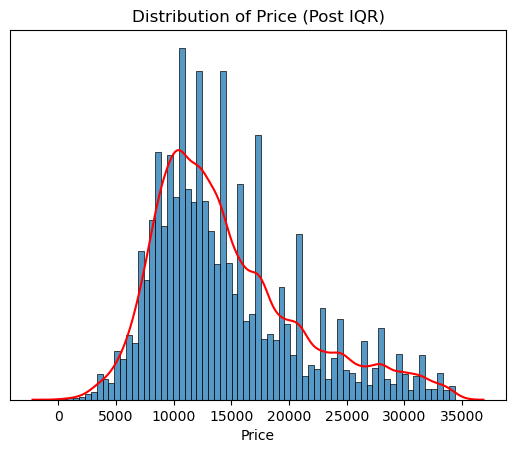

In [64]:
# Deleting df for memory allocation as it is no longer needed
del df

# Checking the distribution of price
ax = sns.histplot(df_iqr, x='price', stat='density')
sns.kdeplot(df_iqr, x='price', color="red")

ax.yaxis.set_visible(False)
plt.title('Distribution of Price (Post IQR)')
plt.xlabel('Price');

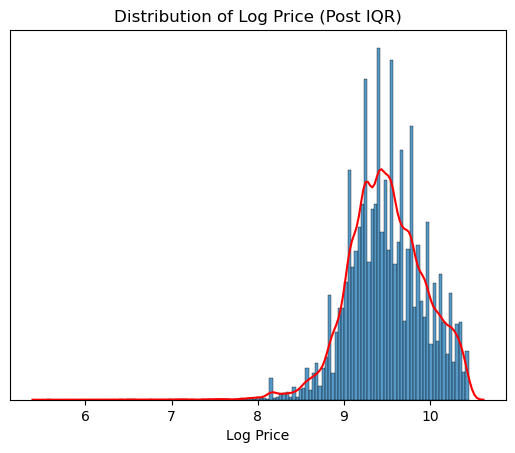

In [65]:
# Creating ln_price and checking distribution
df_iqr['ln_price'] = np.log(df_iqr.price)

# Checking the distribution of ln_price
ax = sns.histplot(df_iqr, x='ln_price', stat='density')
sns.kdeplot(df_iqr, x='ln_price', color="red")

ax.yaxis.set_visible(False)
plt.title('Distribution of Log Price (Post IQR)')
plt.xlabel('Log Price');

There does not appear to be a significant different in the distributions between level and log prices post IQR. Dropping the ln_price column and proceeding with level price calculations

In [66]:
# Dropping ln_price
df_iqr.drop('ln_price', axis=1, inplace=True)

### Non-linear (Lowess) vs Linear (OLS) Scatterplots

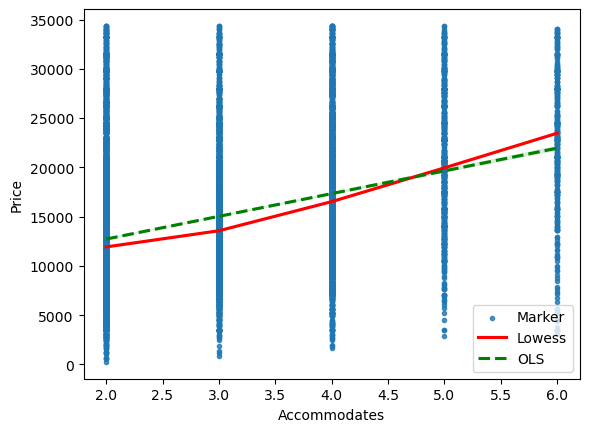

In [67]:
# Lowess
sns.regplot(df_iqr, x = 'n_accommodates', y = 'price', marker= '.', fit_reg= True, lowess= True, line_kws = {'color':'red'})

# OLS
sns.regplot(df_iqr, x = 'n_accommodates', y = 'price', scatter=False, line_kws={'color':'green', 'linestyle': '--'})

plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.legend(['Marker', 'Lowess', 'OLS']); # Unable to figure out how to only show Lowess and OLS in legend, keeping as is

The Lowess and OLS plots are similar enough that the OLS model should do a good job of finding a good fit

#### Checking Interactions

In [68]:
## Helper function for creating plots to check interactions
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=('forestgreen', 'skyblue'))
        + scale_fill_manual(name=dummy_lab, values=('forestgreen', 'skyblue'))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

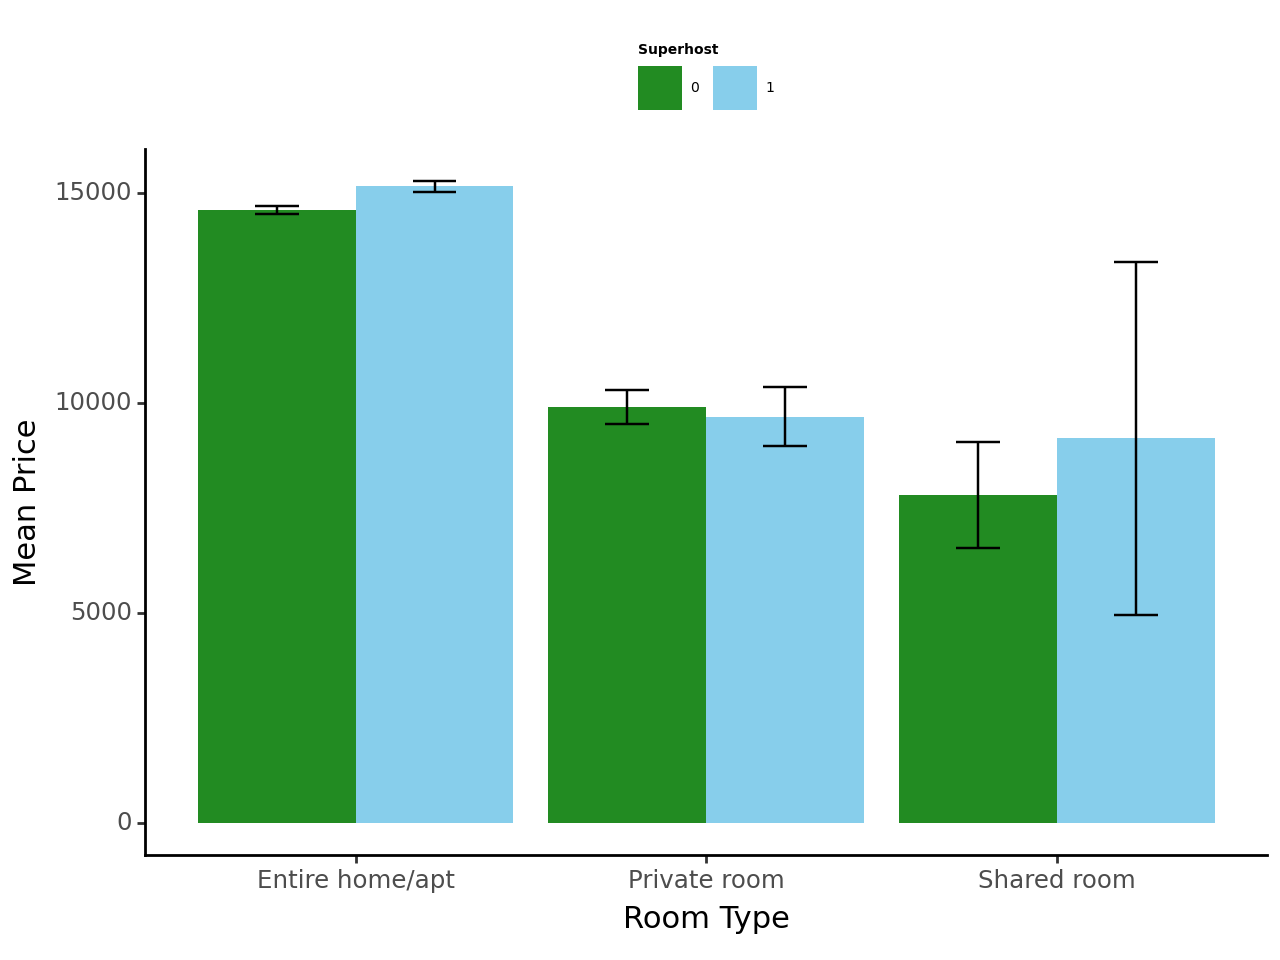

<Figure Size: (640 x 480)>

In [69]:
# Plot of room_type and host_is_superhost
price_diff_by_variables(df_iqr, 'c_room_type', 'n_host_is_superhost', 'Room Type', 'Superhost')

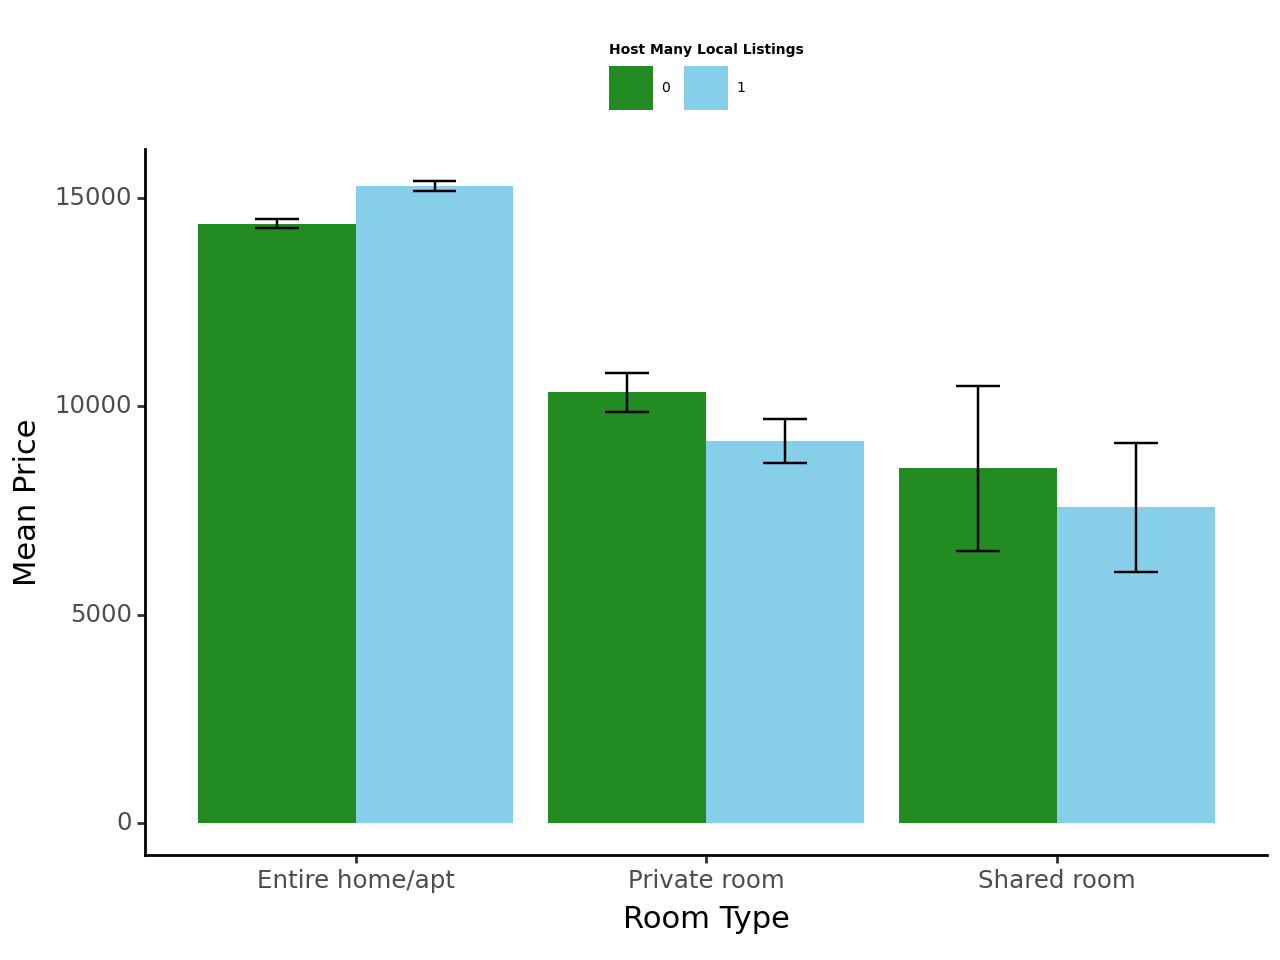

<Figure Size: (640 x 480)>

In [70]:
# Plot of room_type and d_host_many_local_listings
price_diff_by_variables(df_iqr, 'c_room_type', 'd_host_many_local_listings', 'Room Type', 'Host Many Local Listings')

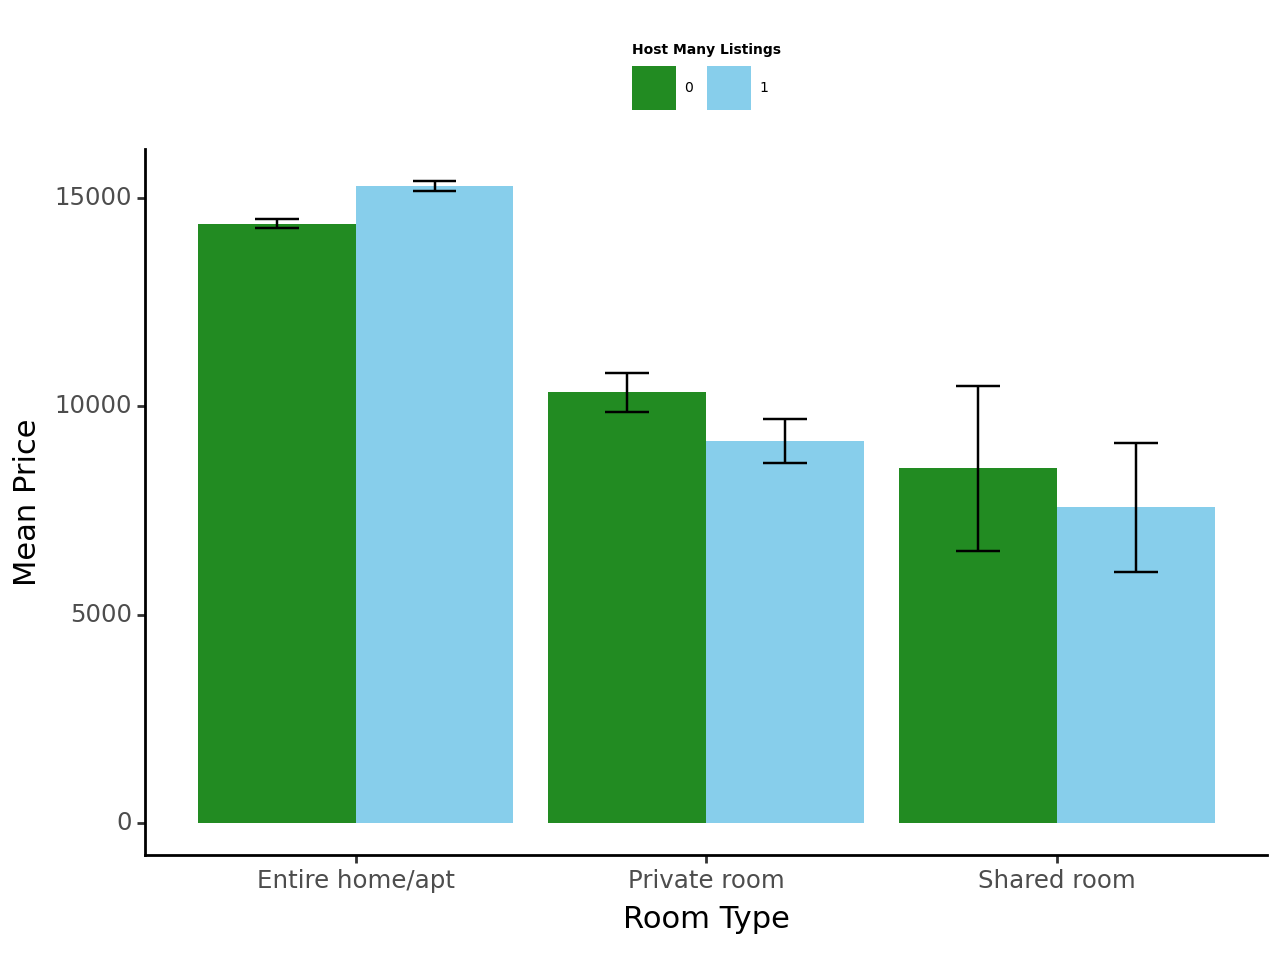

<Figure Size: (640 x 480)>

In [71]:
# Same but with d_host_many_listings
price_diff_by_variables(df_iqr, 'c_room_type', 'd_host_many_local_listings', 'Room Type', 'Host Many Listings')

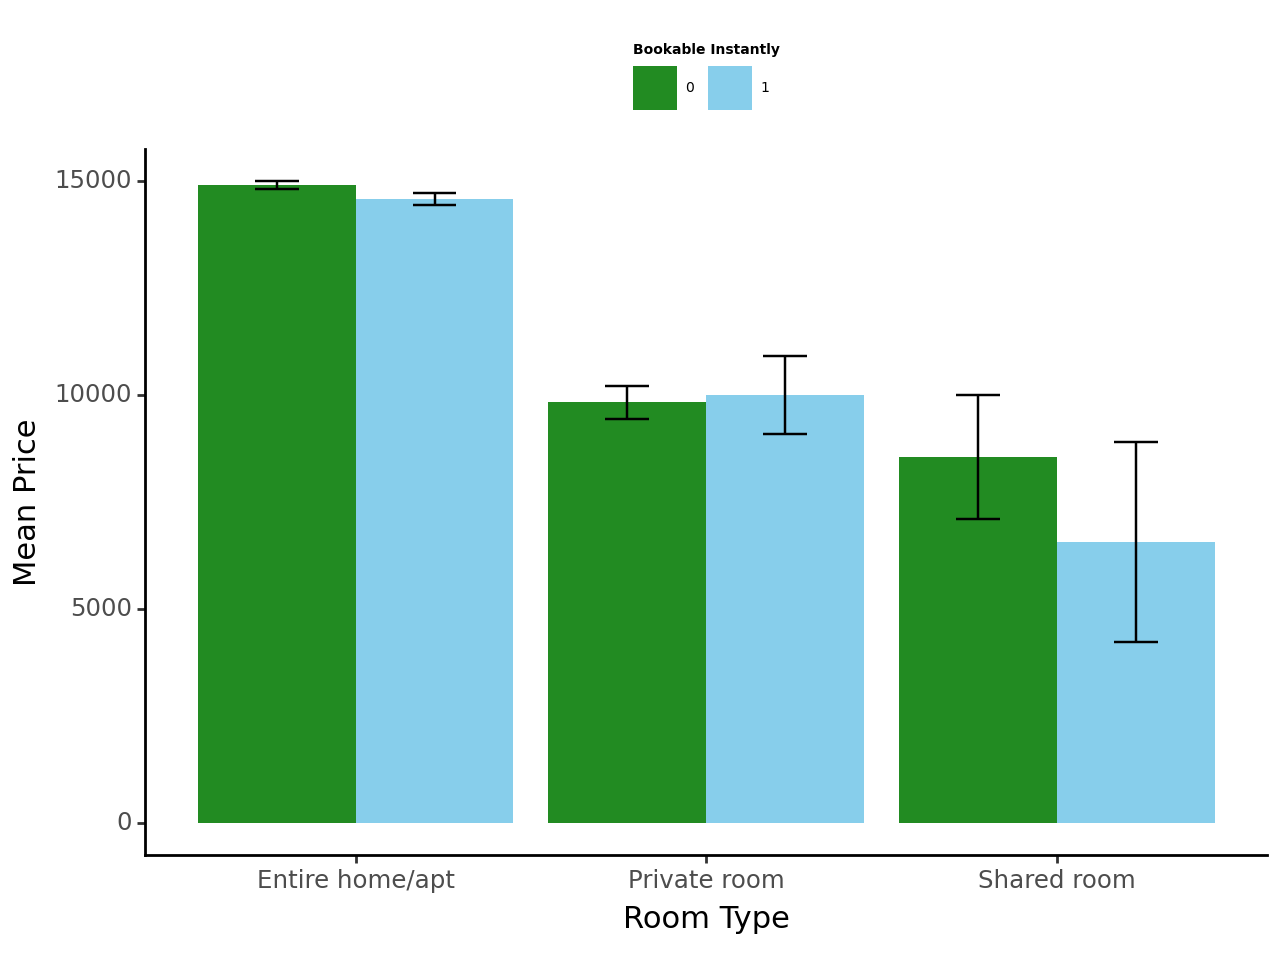

<Figure Size: (640 x 480)>

In [72]:
# Room_type and instant_bookable
price_diff_by_variables(df_iqr, 'c_room_type', 'n_instant_bookable', 'Room Type', 'Bookable Instantly')

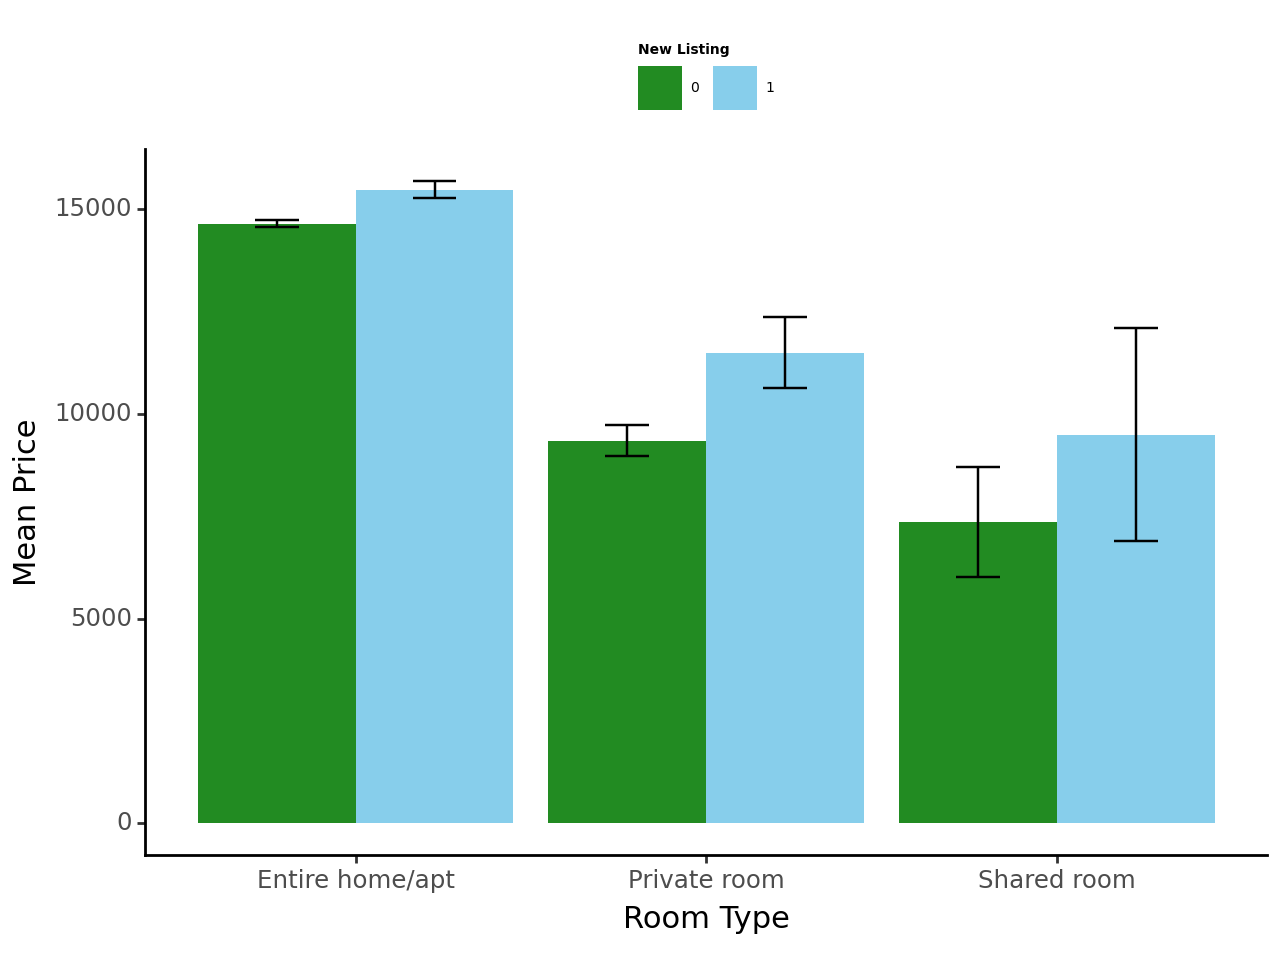

<Figure Size: (640 x 480)>

In [73]:
# Room_type and f_new_listings
price_diff_by_variables(df_iqr, 'c_room_type', 'f_new_listings', 'Room Type', 'New Listing')

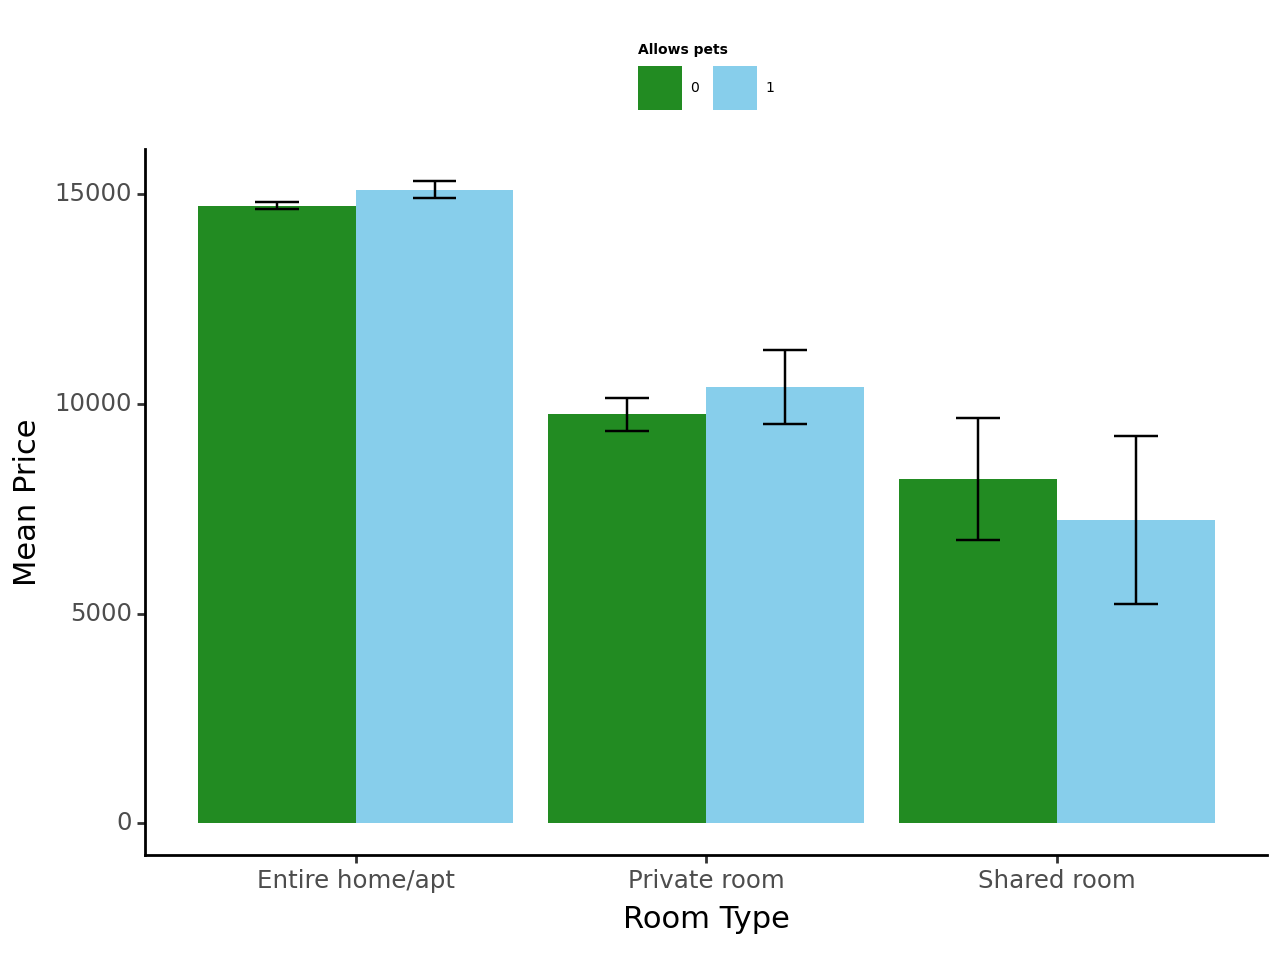

<Figure Size: (640 x 480)>

In [74]:
# Room_type and d_pets
price_diff_by_variables(df_iqr, 'c_room_type', 'd_pets', 'Room Type', 'Allows pets')

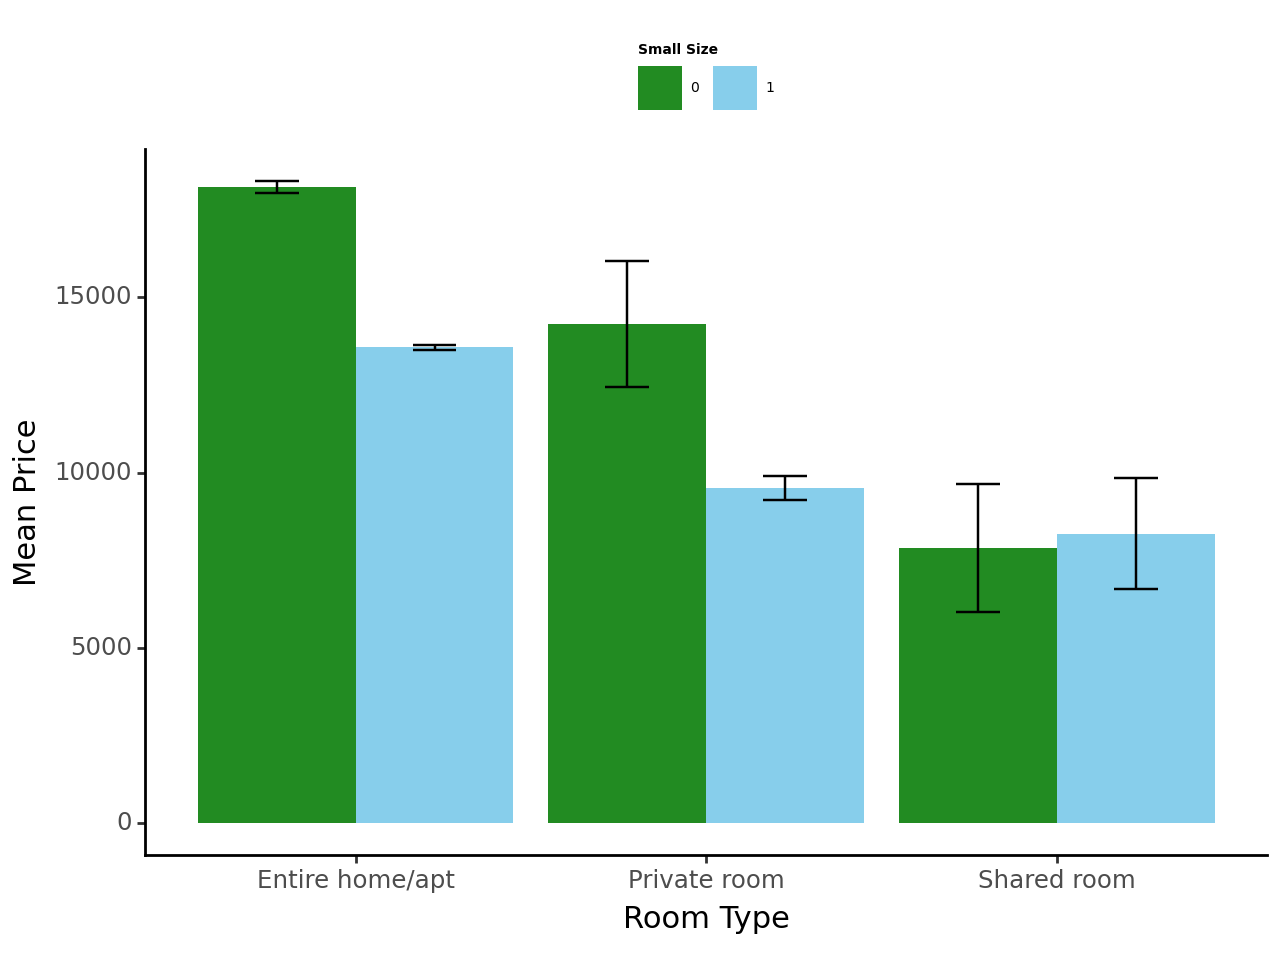

<Figure Size: (640 x 480)>

In [75]:
# Room_type and d_small_size
price_diff_by_variables(df_iqr, 'c_room_type', 'd_small_size', 'Room Type', 'Small Size')

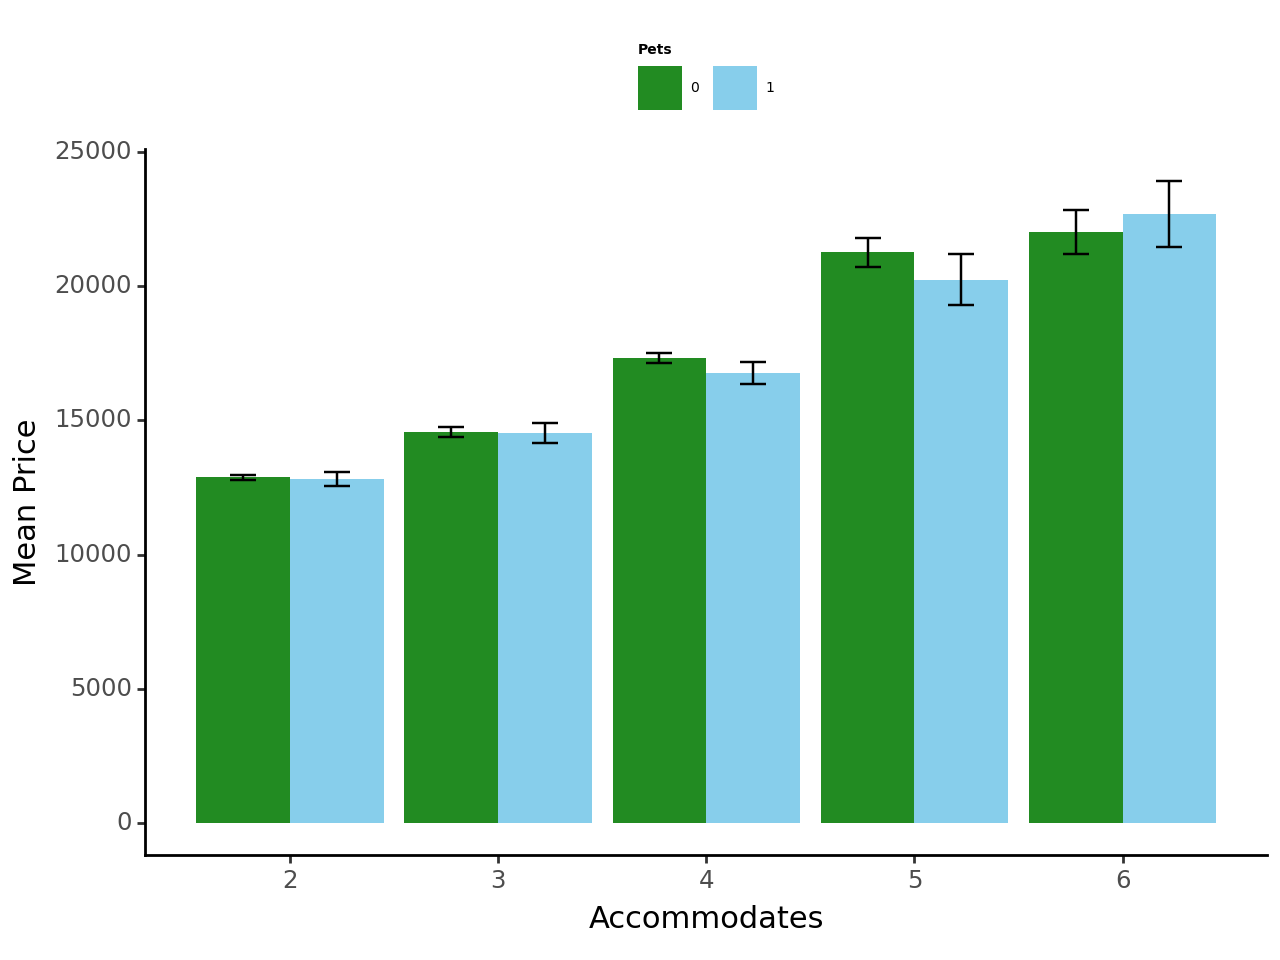

<Figure Size: (640 x 480)>

In [76]:
# Accommodates and d_pets
price_diff_by_variables(df_iqr, 'n_accommodates', 'd_pets', 'Accommodates', 'Pets')

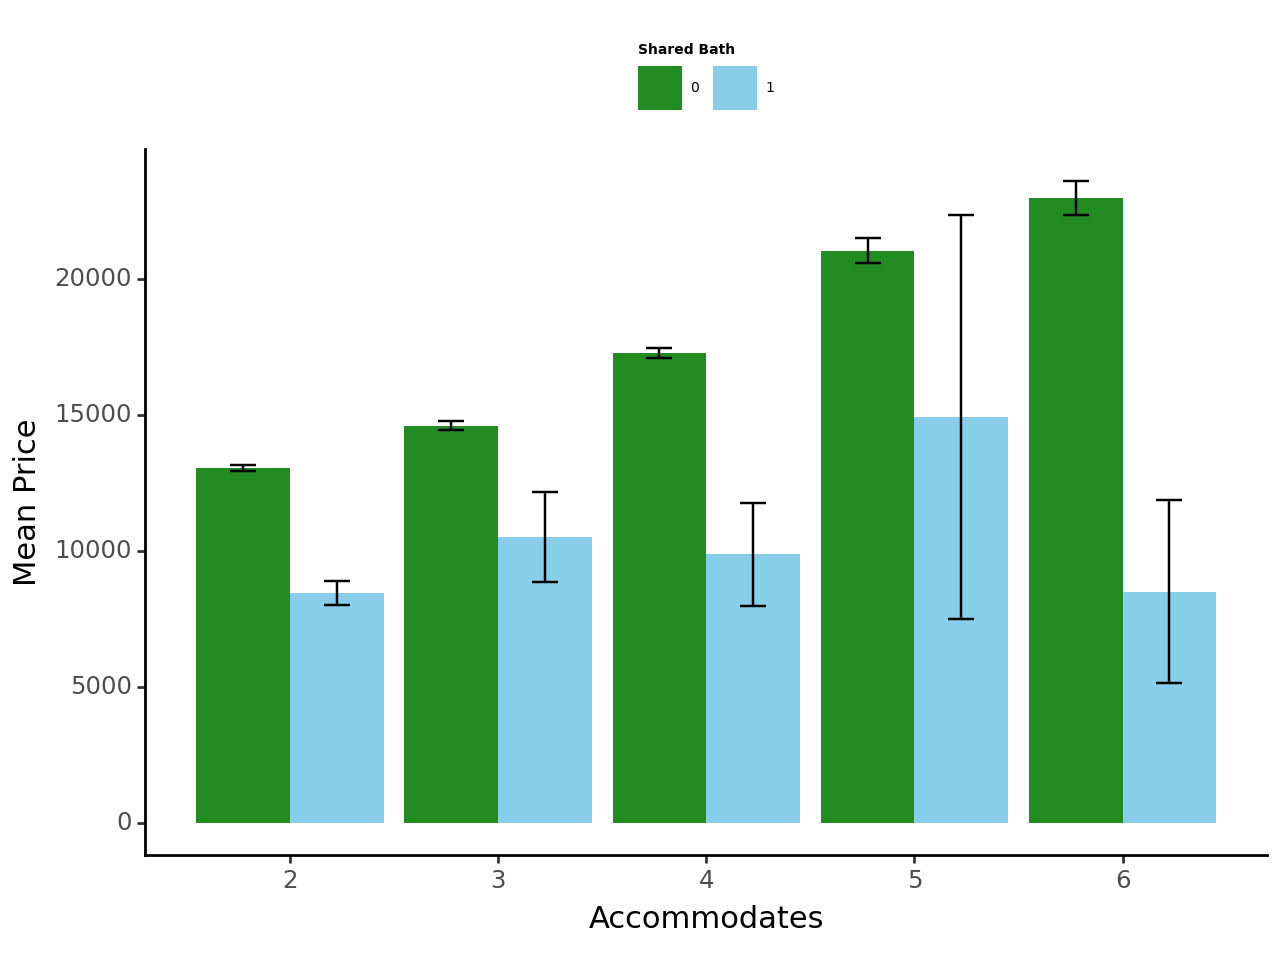

<Figure Size: (640 x 480)>

In [77]:
# Accommodates and d_shared_bath
price_diff_by_variables(df_iqr, 'n_accommodates', 'd_shared_bath', 'Accommodates', 'Shared Bath')

From reviewing the plots, `room_type` seems to have somewhat significant interactions with several dummy variables that have been created. The Shared Room `room_type` only has 58 observations however so there is a lot of innate variance in that data due to lack of data points in comparison to the other two types of rooms available.

---
## Creating Cross Validation set and Holdout set
Using 80%/20% split for the cross validation and holdout sets. The amount of folds used for cross validation will be 5

In [78]:
# Creating the sample size from the data
sample_size = round(0.2 * df_iqr.shape[0])-1

# Setting the seed to make results reproducable
np.random.seed(20240210)

# Creating the cv set and holdout set
df_iqr_cv, df_iqr_holdout = train_test_split(df_iqr, test_size=sample_size)

# Printing shapes of both cv set and holdout set
print(df_iqr_cv.shape)
print(df_iqr_holdout.shape)

(19853, 71)
(4962, 71)


In [79]:
# Setting number of folds
nfolds = 5

# Creating folds
k = KFold(n_splits=nfolds, shuffle=False, random_state=None)

---
## Modeling

Four models will be created. One will be an OLS model done by hand, an OLS model created using LASSO, a Random Forest model, and a model created using the Gradient Boosting Method. These models will be compared against each other to measure their performances.

### Simple Linear Regression
Hand-made thought out OLS model being made for comparison sake.

The model will use `n_accommodates` as the main explanatory variable various categorical and binary/dummy variables being used as well to build the model. The reasoning behind the selections on the price are as follows:
- `c_room_type`, `n_bathrooms`, `n_bedrooms`, and `n_beds` were included because the number of each can sway a person's decision to select one listing over another
- `n_has_availability`, `n_availability_30`, `n_instant_bookable`, `d_high_demand`, and `d_minstay_over_3` were chosen because how soon a listing is available for, for how long a person must rent it for, and how in demand said listing is can affect how often a listing is selected
- `n_host_has_profile_pic`, `n_host_identity_verified`, `n_host_is_superhost`, `d_local_host`, `n_host_response_rate`, and `d_host_many_listings` are all variables to account for iformation about the host potentially influencing the price. If a host is viewed as undesirable in any way it could be likely to negatively affect how a listing performs on the market. This is also meant to account for a particular host that has many listings compared to another that has relatively few
- `c_neighborhood_cleansed`, `d_palermo`, and `d_recoleta` are to account for the neighborhoods. Palerma and Recoleta are two of the fancier and most popular neighborhoods so dummy variables were incuded in the model to account for those
- `n_review_scores_rating` and `d_high_review_score` are to account for review scores influencing price
- `n_number_of_reviews` and `d_high_review_cnt` are to account for the number of reviews of a listing, set a dummy variable for any listing that is considered to have a high amount of reviews
- `d_luxury`, `d_microwave`, `d_patio`, `d_pets`, `d_private_room`, `d_shared_bath`, and `d_toaster` are all dummy variables to account for certain features of a listing, whether it be certain amenities or whether pets are permissable
- `f_new_listings` was included to account whether the listing in question was identified as a new listing or not

For the interaction terms used, they are explained by certain factors potentially having effects on both `room_type` and `accommodates`, for instance the listing of a room type being more or less likely dependent on whether the host is classified as a superhost, whether pets are allowed, whether there are shared baths, and so forth. Same for the number of accommodations in the listing.

In [80]:
# Main explanatory variables
explanatory = ['n_accommodates', 'n_bathrooms', 'n_bedrooms', 'n_beds', 'n_has_availability', 'n_host_has_profile_pic', 'n_host_identity_verified', 'n_host_is_superhost',
               'n_host_response_rate', 'n_instant_bookable', 'c_neighborhood_cleansed', 'n_number_of_reviews', 'n_review_scores_rating', 'f_new_listings', 'n_availability_30', 'c_room_type']

# Dummy variables selected
dummy_vars = ['d_high_demand', 'd_high_review_cnt', 'd_high_review_score', 'd_host_many_listings', 'd_local_host', 'd_luxury',
              'd_microwave', 'd_minstay_over_3', 'd_patio', 'd_pets', 'd_private_room', 'd_shared_bath', 'd_toaster', 
              'd_palermo', 'd_recoleta', 'd_puerto_madero', 'd_small_size']

# Interaction variables created
interactions = ['c_room_type:n_host_is_superhost', 'c_room_type:d_host_many_listings', 'c_room_type:n_instant_bookable', 'c_room_type:f_new_listings', 'c_room_type:d_pets', 'c_room_type:d_patio',
                'n_accommodates:d_pets', 'n_accommodates:f_new_listings', 'n_accommodates:d_shared_bath', 'n_accommodates:n_instant_bookable', 'n_accommodates:d_minstay_over_3',
                'n_accommodates:d_patio', 'n_accommodates:n_bedrooms', 'n_accommodates:n_beds', 'n_accommodates:n_bathrooms']

# Combining all lists
ols_vars = explanatory + dummy_vars + interactions

# Creating OLS model
y, X = dmatrices("price ~ " + " + ".join(ols_vars), df_iqr_cv)

# Running OLS regression
ols_model = LinearRegression().fit(X,y)

# Generating prediction on OLS model
y_hat = ols_model.predict(X)

# Getting RMSE value for OLS model and printing it
ols_rmse = mean_squared_error(y,y_hat,squared=False)
print(f'Workset RMSE: {ols_rmse}')

Workset RMSE: 5230.963271357745


In [81]:
# Getting RMSE value for OLS model prediction on holdout set
y, X = dmatrices('price ~ ' + ' + '.join(ols_vars), df_iqr_holdout)
ols_model = LinearRegression().fit(X,y)
y_hat = ols_model.predict(X)
ols_holdout_rmse = mean_squared_error(y, y_hat, squared=False)
print(f'Holdout RMSE: {ols_holdout_rmse}')

Holdout RMSE: 5054.84070502921


### LASSO Model
Creating a LASSO model using 'alpha' (lambda) tuning. Adding in all the variables and interactions used in the hand-made OLS model but with additional variables, and all dummy variables created. The interaction terms will remain the same. Including more variables to overfit the model so that LASSO can decide whether certain terms are superfluous or if they are meaningful.

In [82]:
# Creating list of variables for LASSO
var_list = ['n_accommodates', 'n_host_is_superhost', 'n_host_total_listings_count', 'n_calculated_host_listings_count',
            'n_bedrooms', 'n_bathrooms', 'n_beds', 'n_availability_30', 'n_instant_bookable', 'n_minimum_nights', 'n_maximum_nights',
            'n_maximum_minimum_nights', 'c_neighborhood_cleansed', 'c_room_type', 'n_host_acceptance_rate', 'n_host_response_rate',
            'c_host_response_time', 'n_host_has_profile_pic', 'n_host_identity_verified', 'n_reviews_per_month', 'c_host_location']
            
reviews = [col for col in df_iqr_cv if col.startswith('n_number_of')]

scores = [col for col in df_iqr_cv if col.startswith('n_review_scores')]

dummies = [col for col in df_iqr_cv if col.startswith('d_')]

flags = ['f_new_listings']

predictors = var_list + reviews + scores + dummies + flags + interactions

In [83]:
# Using L1 for LASSO using ElasticNet
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

# Creating LASSO model
lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# Creating dmatrices
y, X = dmatrices("price ~ " + " + ".join(predictors), df_iqr_cv)

In [84]:
%%time

# Running model
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................alpha=0.05;, score=-5194.068 total time=   6.7s
[CV 2/5] END ....................alpha=0.05;, score=-5237.449 total time=   7.2s
[CV 3/5] END ....................alpha=0.05;, score=-5397.070 total time=   6.9s
[CV 4/5] END ....................alpha=0.05;, score=-5205.031 total time=   7.4s
[CV 5/5] END ....................alpha=0.05;, score=-5187.347 total time=   6.9s
[CV 1/5] END .....................alpha=0.1;, score=-5190.032 total time=   5.4s
[CV 2/5] END .....................alpha=0.1;, score=-5231.863 total time=   6.7s
[CV 3/5] END .....................alpha=0.1;, score=-5392.459 total time=   6.2s
[CV 4/5] END .....................alpha=0.1;, score=-5200.762 total time=   7.3s
[CV 5/5] END .....................alpha=0.1;, score=-5177.523 total time=   4.3s
[CV 1/5] END ....................alpha=0.15;, score=-5186.445 total time=   3.1s
[CV 2/5] END ....................alpha=0.15;, sco

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [85]:
# Checking results
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
c_neighborhood_cleansed[T.Almagro],214.521
c_neighborhood_cleansed[T.Balvanera],482.951
c_neighborhood_cleansed[T.Barracas],1795.053
c_neighborhood_cleansed[T.Belgrano],2229.373
c_neighborhood_cleansed[T.Boca],426.777
...,...
n_accommodates:d_minstay_over_3,0.500
n_accommodates:d_patio,-219.596
n_accommodates:n_bedrooms,462.660
n_accommodates:n_beds,129.211


In [86]:
# Showing best estimator
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.25, l1_ratio=1)

In [87]:
# LASSO model RMSE
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

5227.052491699798

In [88]:
# Getting holdout set prediction from LASSO best estimator
y, X = dmatrices('price ~ ' + ' + '.join(predictors), df_iqr_holdout)

In [89]:
%%time

# Fitting LASSO best model to holdout set
lasso_model_cv.best_estimator_.fit(X, y.ravel())

CPU times: total: 6.47 s
Wall time: 1.66 s


ElasticNet(alpha=0.25, l1_ratio=1)

In [90]:
y_hat = lasso_model_cv.best_estimator_.predict(X)
lasso_holdout_rmse = mean_squared_error(y, y_hat, squared=False)
lasso_holdout_rmse

4820.723074842873

### Random Forest
Creating the Random Forst model using all values used in the LASSO model without the dummy variables or interactions or the flag variable used.

In [91]:
# Creating model list for Random Forest
rf_vars = var_list + reviews + scores

# Running dmatrices for Random Forest to build model
y, X = dmatrices("price ~ " + " + ".join(rf_vars), df_iqr_cv)

In [92]:
# Finding the recommended number of variables to set for the Random Forest using math library
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 24.64.


In [93]:
# Setting random seed for consistency for Random Forest
rfr = RandomForestRegressor(random_state = 20240210)

# Setting tuning parameters for Random Forest. Setting the max features to be +- ~5 on the extremes from the recommended number of varialbles found above
tune_grid = {"max_features": [20, 23, 27, 30], "min_samples_leaf": [5, 10, 15]}

# Creating GridSearch for Random Forest
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [94]:
%%time

# Running the Random Forest model
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=20, min_samples_leaf=5;, score=-5454.540 total time=   1.9s
[CV 2/5] END max_features=20, min_samples_leaf=5;, score=-5612.083 total time=   1.8s
[CV 3/5] END max_features=20, min_samples_leaf=5;, score=-5604.955 total time=   1.7s
[CV 4/5] END max_features=20, min_samples_leaf=5;, score=-5557.780 total time=   1.8s
[CV 5/5] END max_features=20, min_samples_leaf=5;, score=-5607.808 total time=   1.8s
[CV 1/5] END max_features=20, min_samples_leaf=10;, score=-5621.614 total time=   1.4s
[CV 2/5] END max_features=20, min_samples_leaf=10;, score=-5753.039 total time=   1.4s
[CV 3/5] END max_features=20, min_samples_leaf=10;, score=-5712.570 total time=   1.4s
[CV 4/5] END max_features=20, min_samples_leaf=10;, score=-5699.078 total time=   1.4s
[CV 5/5] END max_features=20, min_samples_leaf=10;, score=-5703.684 total time=   1.4s
[CV 1/5] END max_features=20, min_samples_leaf=15;, score=-5714.848 total 

In [95]:
# Creating readable dataframe display of results from Random Forest
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[['param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

# Renaming columns
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

# Displaying RMSEs of all Random Forests
df_rf_model_cv_results.pivot(index = 'max features', columns = 'min node size', values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
20,5567.430,5698.000,5789.310
23,5481.240,5640.100,5705.380
27,5379.230,5489.170,5588.330
30,5306.910,5426.820,5500.070


In [96]:
# Printing best RMSE score
rf_rmse = abs(rf_model.best_score_)
print(rf_rmse)

# Displaying best estimator
rf_model.best_estimator_

5306.905986563872


RandomForestRegressor(max_features=30, min_samples_leaf=5,
                      random_state=20240210)

The best RMSE from the Random Forest model comes from the max features value of 30 parameters with the mninimum number of samples being 5. For better interpretation of what the Random Forest model used, additional diagnostics will be run below for variable importance.

In [97]:
# Creating dataframe for readability for displaying variable importance
rf_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

# Creating cumulative sum column
rf_var_imp['cumulative_imp'] = rf_var_imp['imp'].cumsum()

# Displaying dataframe with formatting
rf_var_imp.style.format({'imp': lambda x: f'{x:,.1%}', 'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_bedrooms,13.9%,13.9%
1,n_accommodates,13.5%,27.4%
2,n_bathrooms,11.1%,38.5%
3,n_beds,6.2%,44.7%
4,c_neighborhood_cleansed[T.Palermo],4.7%,49.4%
5,n_host_total_listings_count,3.3%,52.8%
6,n_availability_30,3.2%,56.0%
7,n_calculated_host_listings_count,3.1%,59.1%
8,n_reviews_per_month,3.1%,62.2%
9,c_room_type[T.Private room],2.5%,64.7%


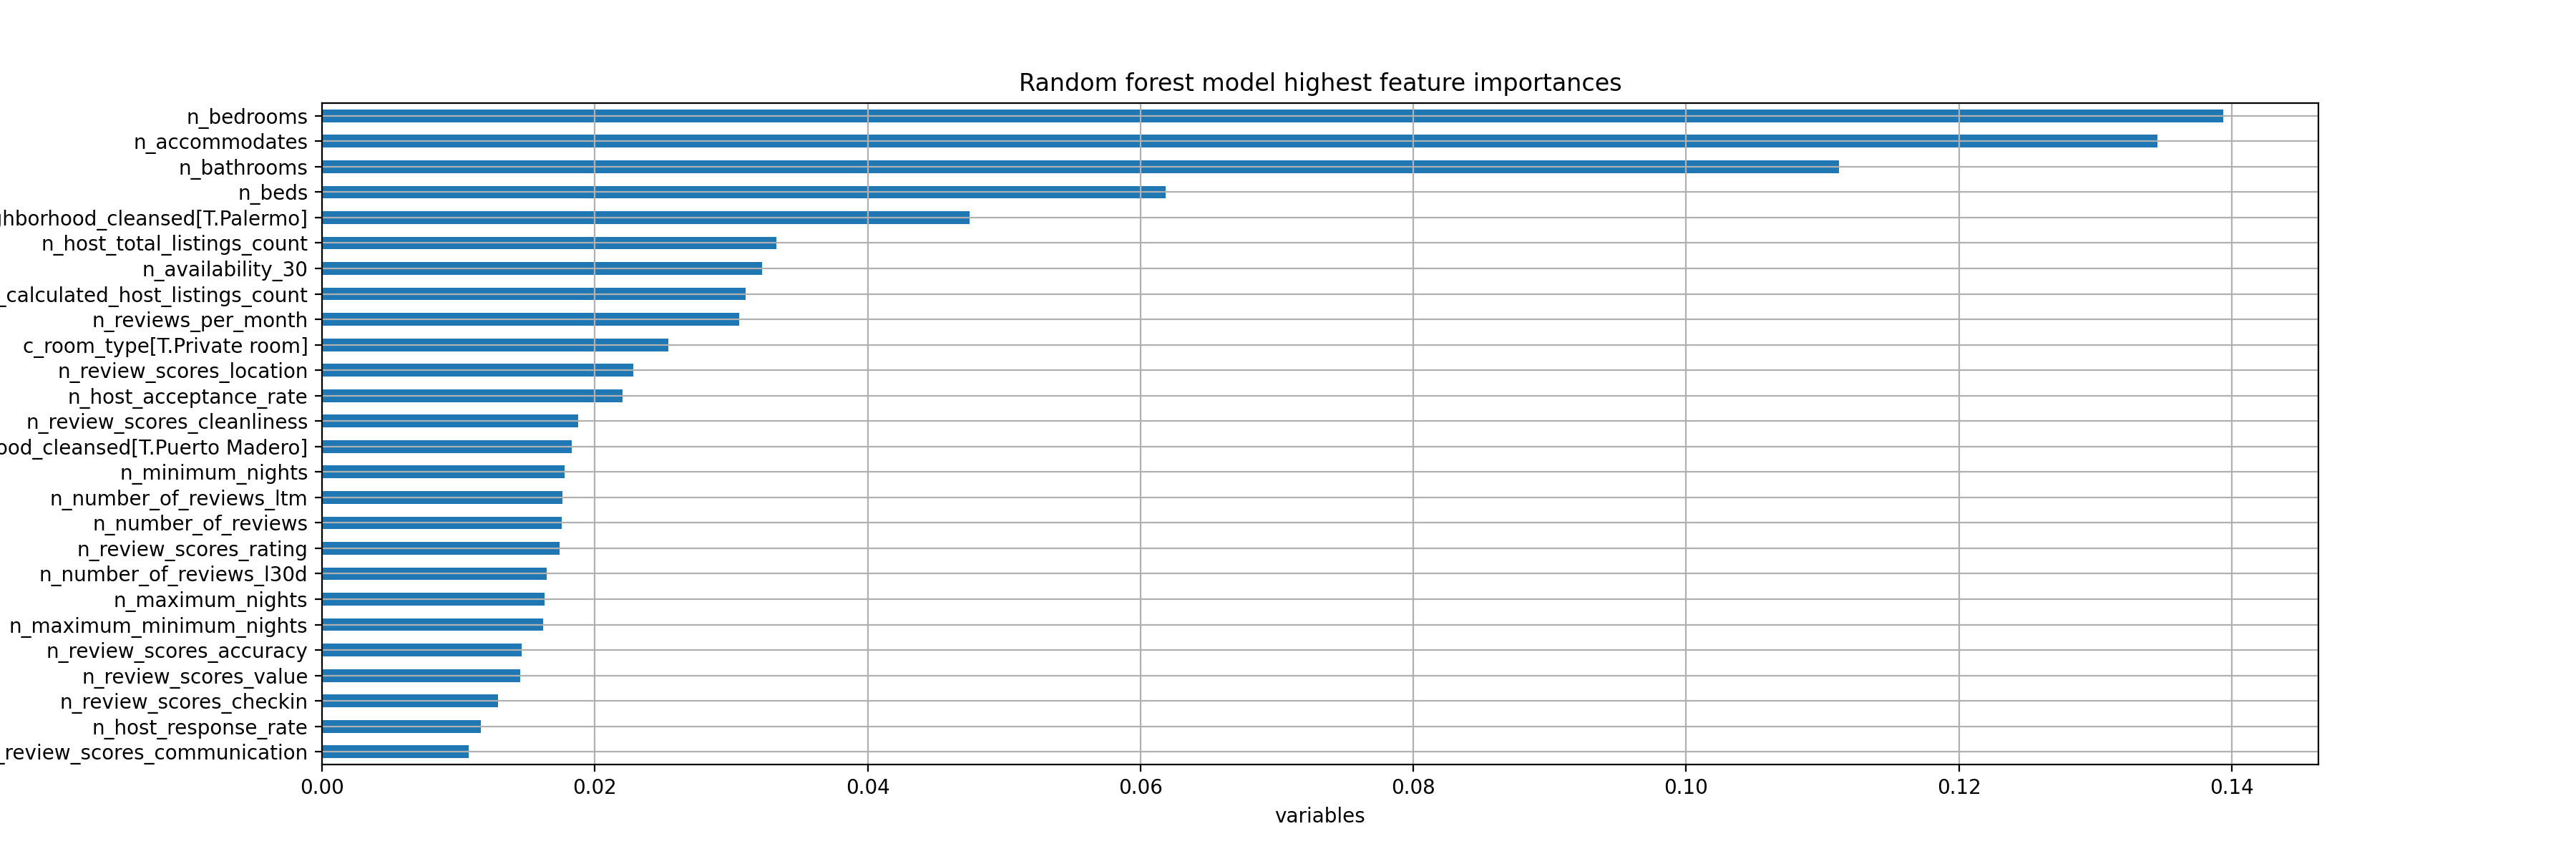

In [98]:
# Using the information from the dataframe but instead plotting it out, setting a cutoff for the variables plotted at more than 1% significance
cutoff = 0.01

rf_var_imp[rf_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (18,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

From the graph we can see that bedrooms, accommodates, and bathrooms are graded out as the most important features. After that the number of beds is important, with also a listing being located in the Palermo neighborhood. Beyond that most of the remaining features are fairly similar in importance.

Now I will run the best estimator on the holdout set.

In [99]:
# Creating lists for categorical columns and numeric columns for the categorical encoder
categorical_columns = [col for col in rf_vars if col.startswith("c_")]
numerical_columns = [col for col in rf_vars if col not in categorical_columns]

# Creating categorical encoder
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

# Preprocessing encoder
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [100]:
%%time

# Fitting the pipeline to the holdout set
rf_pipeline.fit(df_iqr_holdout[rf_vars],df_iqr_holdout.price)

CPU times: total: 2.53 s
Wall time: 2.56 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['c_neighborhood_cleansed',
                                                   'c_room_type',
                                                   'c_host_response_time',
                                                   'c_host_location']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_host_is_superhost',
                                                   'n_host_total_listings_count',
                                                   'n_calculated_host_listings_count',
                                                   'n_bedrooms', 'n_bathrooms',
                                                   'n_be...
                                                   'n_number_of_reviews',
                                                   'n_number_of_reviews_ltm',
                                                   'n_number_of_reviews_l30d',
                                                   'n_review_scores_rating',
                                                   'n_review_scores_accuracy',
                                                   'n_review_scores_cleanliness',
                                                   'n_review_scores_checkin',
                                                   'n_review_scores_communication',
                                                   'n_review_scores_location',
                                                   'n_review_scores_value'])])),
                ('regressor',
                 RandomForestRegressor(max_features=30, min_samples_leaf=5,
                                       random_state=20240210))])

In [101]:
# Creting prediction on holdout set
rf_holdout_predict = rf_pipeline.predict(df_iqr_holdout[rf_vars])

# Getting RMSE score from holdout set
rf_holdout_rmse = mean_squared_error(df_iqr_holdout.price, rf_holdout_predict, squared=False)
rf_holdout_rmse

4236.690877088343

### Gradient Boosting Machine (GBM) Model
Creating a GBM model for comparison to the other models. Using same variables that were used for the Random Forest

In [102]:
# Creating GBM object
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 30)

# Setting tuning parameters
tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

# Setting model covariates via GridSearch
gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

# Creating GBM pipeline
gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [103]:
%%time

# Running GBM
gbm_pipe.fit(df_iqr_cv[rf_vars],df_iqr_cv.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  28.6s
CPU times: total: 6.69 s
Wall time: 28.6 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['c_neighborhood_cleansed',
                                                   'c_room_type',
                                                   'c_host_response_time',
                                                   'c_host_location']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_host_is_superhost',
                                                   'n_host_total_listings_count',
                                                   'n_calculated_host_listings_count',
                                                   'n_bedrooms', 'n_bathrooms',
                                                   'n_be...
                                                   'n_review_scores_checkin',
                                                   'n_review_scores_communication',
                                                   'n_review_scores_location',
                                                   'n_review_scores_value'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=30,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [104]:
# Printing best GBM RMSE score
gbm_rmse = gbm_model_cv.best_score_*-1
print(gbm_rmse)

# Showing best GBM estimator results
gbm_model_cv.best_estimator_

4743.294833897116


GradientBoostingRegressor(max_depth=10, max_features=30, min_samples_split=20,
                          n_estimators=300)

In [105]:
# Making prediciton on holdout set using the best model from GBM
gbm_best_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv.best_estimator_)], verbose=True
)

In [106]:
%%time

# Fitting best GBM model to holdout set
gbm_best_pipe.fit(df_iqr_holdout[rf_vars],df_iqr_holdout.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
CPU times: total: 2.8 s
Wall time: 2.85 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['c_neighborhood_cleansed',
                                                   'c_room_type',
                                                   'c_host_response_time',
                                                   'c_host_location']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_host_is_superhost',
                                                   'n_host_total_listings_count',
                                                   'n_calculated_host_listings_count',
                                                   'n_bedrooms', 'n_bathrooms',
                                                   'n_be...
                                                   'n_number_of_reviews_ltm',
                                                   'n_number_of_reviews_l30d',
                                                   'n_review_scores_rating',
                                                   'n_review_scores_accuracy',
                                                   'n_review_scores_cleanliness',
                                                   'n_review_scores_checkin',
                                                   'n_review_scores_communication',
                                                   'n_review_scores_location',
                                                   'n_review_scores_value'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=10, max_features=30,
                                           min_samples_split=20,
                                           n_estimators=300))],
         verbose=True)

In [107]:
# Creating prediction on holdout set
gbm_holdout_predict = gbm_best_pipe.predict(df_iqr_holdout[rf_vars])

# Getting RMSE score from holdout set
gbm_holdout_rmse = mean_squared_error(df_iqr_holdout.price, gbm_holdout_predict, squared=False)
gbm_holdout_rmse

1867.5798903922573

---
## Model Comparisons
Now comparing the models based on their performance on the training set

In [108]:
# Training set RMSE comparison between models
pd.DataFrame({'model': ['OLS', 'LASSO', 'RF', 'GBM'],
              'Workset RMSE': [ols_rmse, lasso_rmse, rf_rmse, gbm_rmse],
              'Holdout RMSE': [ols_holdout_rmse, lasso_holdout_rmse, rf_holdout_rmse, gbm_holdout_rmse]})

,model,Workset RMSE,Holdout RMSE
0,OLS,5230.963,5054.841
1,LASSO,5227.052,4820.723
2,RF,5306.906,4236.691
3,GBM,4743.295,1867.580


From the results it can be seen that the GBM model has by far the lowest RMSE of the bunch, both on the workset and on the holdout set. The hand-made OLS model performs the worst, which implies that there are a fair amount of variance that is not being accounted for properly when I theorized about what to include in the model.

The LASSO model performs better on the workset than the Random Forest model but then performs much worse on the holdout set compared to the Random Forest model. The LASSO model also takes longer to process than any of the other models chosen and therefore is not worth the effort in creating in this instance.

The Random Forest model, as mentioned before, does not perform as well when comparing RMSE values on the workset but is clearly a much better model on the holdout set than the LASSO model implying that the LASSO model is overfitted in comparison to the Random Forest model.
.
The GBM model performs the best on the workset and by far the best on the holdout set. It would appear that gradient boosting for this dataset is far and away the superior model for running predictions with live data.

In [109]:
# Creating dataframe from holdout set and then adding price predictions
gbm_predict_results = df_iqr_holdout
gbm_predict_results['price_predictions'] = gbm_holdout_predict

In [117]:
# Function to calculate RMSE based on selection of neighborhood
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.price_predictions, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price_predictions)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [122]:
# Showing dataframe for top represented neighborhoods with GBM mean price predictions
neighborhoods = gbm_predict_results.loc[
    lambda x: x.c_neighborhood_cleansed.isin(
        [
            "Palermo",
            "Recoleta",
            "San Nicolas",
            "Belgrano",
            "Retiro",
            "Puerto Madero",
        ]
    )
].groupby(['c_neighborhood_cleansed', 'd_small_size'])
neighborhood_subset = calculate_rmse(neighborhoods)

neighborhood_subset.rename(columns={'rmse': 'RMSE', 'mean_price': 'Avg Pred Price'}, inplace=True)

neighborhood_subset

RMSE  Avg Pred Price  rmse_norm
c_neighborhood_cleansed d_small_size                                    
Belgrano                0            1643.550       17929.570      0.090
                        1            1978.320       13355.760      0.150
Palermo                 0            2062.820       19685.090      0.100
                        1            2099.870       14753.640      0.140
Puerto Madero           0            1063.090       27514.460      0.040
                        1            1372.610       23506.110      0.060
Recoleta                0            1848.760       18994.600      0.100
                        1            2013.460       13773.660      0.150
Retiro                  0            1638.360       17419.170      0.090
                        1            1551.580       13447.450      0.120
San Nicolas             0            1654.520       16338.580      0.100
                        1            1680.760       11784.750      0.140

This shows the average predicted price for major neighborhoods in Buenos Aires separated by whether the listing is consdered small or not, along with their corresponding mean RMSE values using the GBM model. From here a company could determine a good price to potentially set for a new AirBnB listing depending on where the listing is located at. The rmse_norm column shows where the model does a better job of making a prediction relative to the price level in that neighborhood and where it doesn't. The lower the norm value the better the model performs.